In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        # Get details of each GPU
        details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU Name: {details['device_name']}")
else:
    print("No GPUs found.")

GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
import numpy as np

In [4]:
!pip install pillow

In [5]:
!pip install tqdm

In [6]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [1]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump, load
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add  # Using Add instead of merge.add
from tensorflow.keras.utils import plot_model




In [8]:
!pip install ipywidgets


In [2]:
from tqdm.notebook import tqdm
tqdm.pandas()



In [3]:
# Load the document file into memory
import string

# Function to load the text from a file
def load_fp(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Function to get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        img_id = img[:-2]
        if img_id not in descriptions:
            descriptions[img_id] = [caption]
        else:
            descriptions[img_id].append(caption)
    return descriptions

# Function to clean text by converting to lowercase, removing punctuation, and words with numbers
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Convert to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each word
            descp = [wrd.translate(table) for wrd in descp]
            # Remove words with length <= 1 and words containing numbers
            descp = [wrd for wrd in descp if len(wrd) > 1 and wrd.isalpha()]
            # Convert back to string
            captions[img][i] = ' '.join(descp)
    return captions

# Function to build vocabulary of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# Function to save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(f"{key}\t{desc}")
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

# Paths
dataset_text = r"C:\Users\SIVA VENKATESH M\Downloads\Flickr8k_text"
dataset_images = r"C:\Users\SIVA VENKATESH M\Downloads\Flickr8k_Dataset\Flicker8k_Dataset"
filename = dataset_text + "/" + "Flickr8k.token.txt"

# Loading the file with captions
descriptions = img_capt(filename)
print("Length of descriptions =", len(descriptions))
 
# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# Building vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions to a file
save_descriptions(clean_descriptions, "descriptions.txt")


Length of descriptions = 8092
Length of vocabulary = 8422


In [4]:
model = Xception( include_top=False, pooling='avg')

In [5]:
def extract_features(directory):
    features = {}
    for img_name in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        image = Image.open(img_path)
        image = image.resize((299, 299))
        image = np.array(image)
        image = np.expand_dims(image, axis=0)
        # Normalize the image as expected by the Xception model
        image = image / 127.5 - 1.0
        feature = model.predict(image)
        features[img_name] = feature
    return features

# Directory path for the images
dataset_images = r"C:\Users\SIVA VENKATESH M\Downloads\Flickr8k_Dataset\Flicker8k_Dataset"

# Extract and save features
features = extract_features(dataset_images)
dump(features, open("features.p", "wb"))

# To directly load the features from the pickle file
features = load(open("features.p", "rb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Load the image filenames
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]  # Split by new line and remove the last empty element
    return photos

# Load and clean the descriptions
def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):  # Iterate through lines
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = ' '.join(image_caption)  # Join the description tokens into a sentence
            descriptions[image].append(desc)
    return descriptions

# Load features from a pickle file
def load_features(photos):
    # Load all features from a pickle file
    with open("features.p", "rb") as f:
        all_features = load(f)
    # Select only the features needed
    features = {k: all_features[k] for k in photos}
    return features

# Define your dataset path (make sure this is correct)
dataset_text = r"C:\Users\SIVA VENKATESH M\Downloads\Flickr8k_text"

# Load the training images file
filename = os.path.join(dataset_text, "Flickr_8k.trainImages.txt")

# Load the training images, descriptions, and features
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

print(f"Loaded {len(train_imgs)} training images.")
print(f"Loaded {len(train_descriptions)} descriptions.")
print(f"Loaded {len(train_features)} features.")

Loaded 6000 training images.
Loaded 6000 descriptions.
Loaded 6000 features.


In [7]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        # Appending all descriptions in the list for each image
        all_desc.extend(descriptions[key])  # Using extend instead of append to flatten the list
    return all_desc

# Create tokenizer to vectorize text corpus
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)  # Get all descriptions as a list
    tokenizer = Tokenizer()  # Initialize the tokenizer
    tokenizer.fit_on_texts(desc_list)  # Fit tokenizer on the description texts
    return tokenizer

# Create tokenizer for the training descriptions
tokenizer = create_tokenizer(train_descriptions)

# Save the tokenizer to a pickle file
dump(tokenizer, open('tokenizer.p', 'wb'))

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Vocabulary size: {vocab_size}")

# Calculate the maximum length of descriptions to decide model structure parameters
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)  # Get all descriptions as a list
    return max(len(d.split()) for d in desc_list)  # Return the max number of words in a description

# Calculate the max length of descriptions
max_len = max_length(train_descriptions)
print(f"Max length of description: {max_len}")


Vocabulary size: 7318
Max length of description: 33


In [8]:
# Ensure you are calling the function max_length to get the actual value
max_length = max_length(train_descriptions)  # Get the max length for the descriptions

# Data generator for training, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:  # Infinite loop to keep generating data
        for key, description_list in descriptions.items():
            # Retrieve photo features
            feature = features[key][0]
            # Create input/output sequences
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            # Yield the data as input and output pair for model training
            yield [[inp_image, inp_seq], op_word]

# Create sequences of input/output pairs
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()

    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # Divide one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            # Input sequence (X) and output sequence (y)
            in_seq, out_seq = seq[:i], seq[i]

            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            # Encode output sequence (one-hot encoding)
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            # Store the sequences
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)

    return np.array(x_1), np.array(x_2), np.array(y)

# To check the shape of the input and output for your model
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))
print(a.shape, b.shape, c.shape)


(37, 2048) (37, 33) (37, 7318)


In [9]:
def define_model(vocab_size, max_length):
    # Features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))  # Input layer for image features
    fe1 = Dropout(0.5)(inputs1)  # Apply Dropout regularization
    fe2 = Dense(256, activation='relu')(fe1)  # Dense layer to compress features

    # LSTM sequence model for the text
    inputs2 = Input(shape=(max_length,))  # Input layer for sequences
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)  # Embedding layer
    se2 = Dropout(0.5)(se1)  # Apply Dropout to sequence embeddings
    se3 = LSTM(256)(se2)  # LSTM layer for sequence processing

    # Merge both the feature model and the sequence model
    decoder1 = add([fe2, se3])  # Merge the features and the LSTM output
    decoder2 = Dense(256, activation='relu')(decoder1)  # Dense layer after merge
    outputs = Dense(vocab_size, activation='softmax')(decoder2)  # Output layer for vocabulary prediction

    # Define the model that takes image features and sequences as input and predicts the next word
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    # Compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Print the summary of the model to check layers and parameters
    print(model.summary())

    # Plot the model architecture and save it as an image file
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [10]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

# Define the model
model = define_model(vocab_size, max_length)

# Hyperparameters
epochs = 25
steps = len(train_descriptions)

# Create the models directory if it doesn't exist
if not os.path.exists("models"):
    os.mkdir("models")

# Training loop
for i in range(epochs):
    # Prepare the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    
    # Use model.fit() instead of fit_generator()
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    # Save the model after each epoch
    model.save(f"models/model_{i}.h5")

    print(f"Epoch {i+1}/{epochs} complete. Model saved to models/model_{i}.h5.")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7318
Description Length:  33
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 256)      1873408     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']    

C:\anaconda\envs\gpu_env\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6000/6000 [==============================] - 323s 54ms/step - loss: 3.9450
Epoch 2/25 complete. Model saved to models/model_1.h5.
6000/6000 [==============================] - 311s 52ms/step - loss: 3.6145
Epoch 3/25 complete. Model saved to models/model_2.h5.
6000/6000 [==============================] - 308s 51ms/step - loss: 3.4155
Epoch 4/25 complete. Model saved to models/model_3.h5.
6000/6000 [==============================] - 314s 52ms/step - loss: 3.2734
Epoch 5/25 complete. Model saved to models/model_4.h5.
6000/6000 [==============================] - 310s 52ms/step - loss: 3.1718
Epoch 6/25 complete. Model saved to models/model_5.h5.
6000/6000 [==============================] - 309s 52ms/step - loss: 3.0883
Epoch 7/25 complete. Model saved to models/model_6.h5.
6000/6000 [==============================] - 311s 52ms/step - loss: 3.0244
Epoch 8/25 complete. Model saved to models/model_7.h5.
6000/6000 [==============================] - 317s 53ms/step - loss: 2.9664
Epoch 9/25 comp

Generated Description:
the girl is swimming underwater in pool 


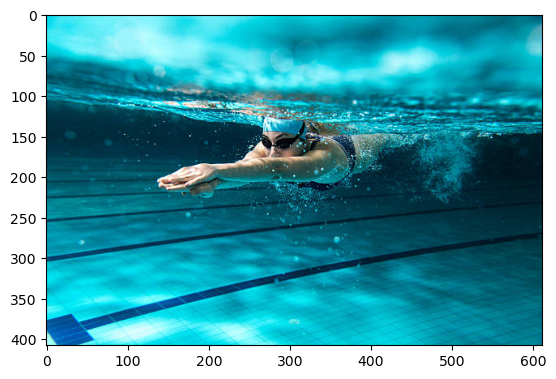

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf


# Hardcode the image path here
img_path = r"C:\Users\SIVA VENKATESH M\Downloads\demo1.jpg" # Replace with the actual image path

# Function to extract features using Xception model
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
        return None
    
    # Resize and preprocess image
    image = image.resize((299, 299))
    image = np.array(image)
    
    # For images with 4 channels, convert to 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    
    image = np.expand_dims(image, axis=0)
    image = image / 127.5  # Normalize image
    image = image - 1.0    # Shift pixel values to [-1, 1]
    
    feature = model.predict(image)
    return feature

# Function to convert integer to word

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate description from the model
def generate_desc(model, tokenizer, photo, max_length, target_length=8):
    in_text = ''
    
    for i in range(max_length):
        # Convert the current text to a sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        # Stop if no word is predicted
        if word is None:
            break
        
        in_text += ' ' + word
        
        # Stop if 'end' is reached or target word count is met
        if word == '' or len(in_text.split()) >= target_length:
            break

    # Ensure 'end' is the last word
    words = in_text.split()[:target_length]  # Limit to target length
    if words[-1] != '':
        words[-1] = ''  # Replace last word with 'end' if needed
    
    return ' '.join(words)


# Load tokenizer and model
max_length = 33
tokenizer = pickle.load(open("tokenizer.p", "rb"))
model = load_model('models/model_24.h5')

# Load Xception model for feature extraction
xception_model = Xception(include_top=False, pooling="avg")

# Extract features from the image
photo = extract_features(img_path, xception_model)

if photo is not None:
    # Generate description for the image
    description = generate_desc(model, tokenizer, photo, max_length)
    print("Generated Description:")
    print(description)
    
    # Display image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
else:
    print("Failed to extract features. Please check the image path.")
